# **Neural Networks for model selection,**
# **$\mathcal{C}^{EE}_{\ell} + \mathcal{C}^{TE}_{\ell} + \mathcal{C}^{TT}_{\ell}$ data**
## Hu-Sawicki f(R) vs ΛCDM
Can the NN differentiate between HS f(R) and ΛCDM models at the level of the CMB angular power spectrum?

In [1]:
#Import packages
import pandas as pd
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers.experimental.preprocessing import Normalization
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam

### Read and visualize the data (simulated out of [CLASS](https://github.com/lesgourg/class_public) and the [ESA Planck Archival](https://pla.esac.esa.int/#home))

In [2]:
#Read the data LCDM & MoG
J = 'joint'
label = '_FR0_e-6_FRn'
planck_df_LCDM_tt = np.genfromtxt('./simulated_data/TT_polarization/ttcls_MoGgrids_noisy_FR0_LCDM.csv', delimiter=',')
planck_df_LCDM_te = np.genfromtxt('./simulated_data/TE_polarization/tecls_MoGgrids_noisy_FR0_LCDM.csv', delimiter=',')
planck_df_LCDM_ee = np.genfromtxt('./simulated_data/EE_polarization/eecls_MoGgrids_noisy_FR0_LCDM.csv', delimiter=',')
planck_cls_LCDM = np.column_stack((planck_df_LCDM_tt[1:], planck_df_LCDM_te[1:], planck_df_LCDM_ee[1:])) # get rid of the first column, i.e. multipole moment l

planck_df_MoG_tt = np.genfromtxt('./simulated_data/TT_polarization/ttcls_MoGgrids_noisy%s.csv'%label, delimiter=',')
planck_df_MoG_te = np.genfromtxt('./simulated_data/TE_polarization/tecls_MoGgrids_noisy%s.csv'%label, delimiter=',')
planck_df_MoG_ee = np.genfromtxt('./simulated_data/EE_polarization/eecls_MoGgrids_noisy%s.csv'%label, delimiter=',')
planck_cls_MoG = np.column_stack((planck_df_MoG_tt[1:], planck_df_MoG_te[1:], planck_df_MoG_ee[1:]))

ls = np.concatenate((planck_df_LCDM_tt[0].flatten(), planck_df_LCDM_te[0].flatten(), planck_df_LCDM_ee[0].flatten()))
#Add the model class: 
LCDM_class = np.zeros(len(planck_cls_LCDM))
MoG_class = np.ones(len(planck_cls_MoG))
#The full arrays (+target):
cls_LCDM_class = np.column_stack((planck_cls_LCDM, LCDM_class))
cls_MoG_class = np.column_stack((planck_cls_MoG, MoG_class))

#Full data set
cls_full_dataset = np.concatenate((planck_cls_LCDM, planck_cls_MoG)) #without the class: x_dataset
dataset_class = np.concatenate((LCDM_class, MoG_class)) #only the class: y_dataset
cls_full_dataset_class = np.concatenate((cls_LCDM_class, cls_MoG_class)) #with the class: xy_dataset

Text(0, 0.5, '$\\mathcal{C}_{\\ell}(\\Lambda CDM)$ - $\\mathcal{C}_{\\ell} (MoG)$')

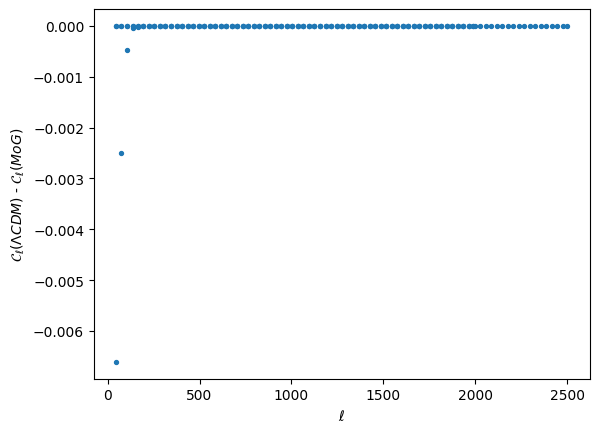

In [3]:
plt.scatter(ls,planck_cls_LCDM[0]-planck_cls_MoG[0], s=8)
plt.xlabel('${\ell}$')
plt.ylabel('$\mathcal{C}_{\ell}(\Lambda CDM)$ - $\mathcal{C}_{\ell} (MoG)$')

## Angular power spectrum (all the components)

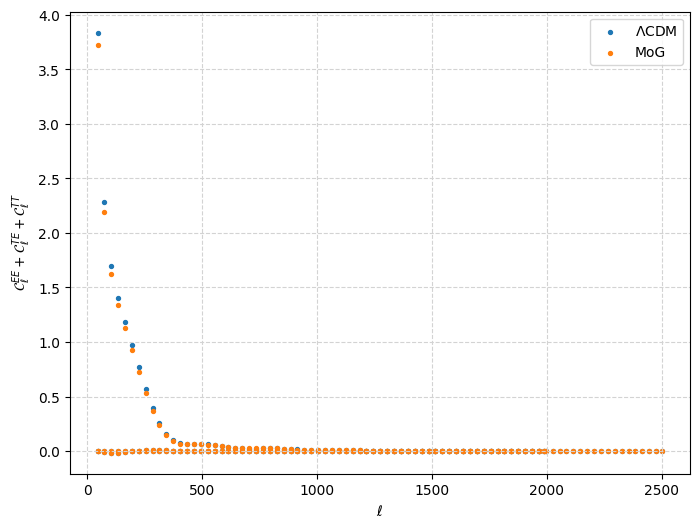

In [4]:
#-----------------------------------------------------------------------------------------------------------------------
#Plot Cls
#-----------------------------------------------------------------------------------------------------------------------
fig = plt.figure(figsize=(8,6))
plt.scatter(ls,cls_full_dataset[50:][0], label='$\Lambda$CDM', marker='o', s=8)
plt.scatter(ls,cls_full_dataset[50:][249], label='MoG', marker='o', s=8)
plt.xlabel('${\ell}$')
plt.ylabel(' $\mathcal{C}^{EE}_{\ell} + \mathcal{C}^{TE}_{\ell} + \mathcal{C}^{TT}_{\ell}$')
plt.legend()
plt.grid(color='lightgray', linestyle='--')

In [5]:
#-----------------------------------------------------------------------------------------------------------------------
#Dls
#-----------------------------------------------------------------------------------------------------------------------
# Create a function for converting the C_ls to Dls Tcmb=2.7255
def Dls(l,Cls):
    Dl = [l[i]*(l[i]+1)*Cls[i]/((2*math.pi)*(2.7255*10**6)**2) for i in range(len(l))]
    return Dl
#-----------------------------------------------------------------------------------------------------------------------

### Z-score normalization of the joint data

Text(0, 0.5, 'Normalized $\\mathcal{C}^{EE}_{\\ell} + \\mathcal{C}^{TE}_{\\ell} + \\mathcal{C}^{TT}_{\\ell}$')

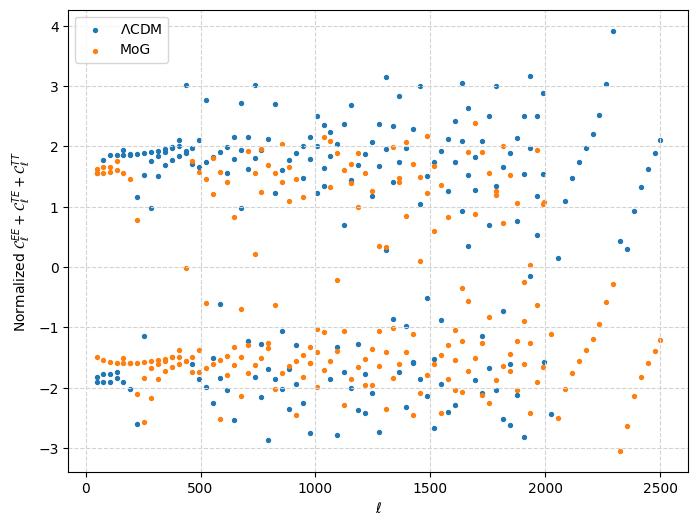

In [6]:
#-------------------------------------------------------------------------------------------------------------
#Normalization and visualization
#-------------------------------------------------------------------------------------------------------------
fig = plt.figure(figsize=(8,6))
normalize = Normalization()
normalize.adapt(cls_full_dataset)
normalized_data = normalize(cls_full_dataset)
plt.scatter(ls,normalized_data[0], label='$\Lambda$CDM', marker='o', s=8)
plt.scatter(ls,normalized_data[-1], label='MoG', marker='o', s=8)
plt.grid(color='lightgray', linestyle='--')
plt.legend()
plt.xlabel('${\ell}$')
plt.ylabel('Normalized $\mathcal{C}^{EE}_{\ell} + \mathcal{C}^{TE}_{\ell} + \mathcal{C}^{TT}_{\ell}$')
#fig.savefig('./figures/Normalized_DimLess_Cls.pdf')

In [7]:
#Z-SCORE verification
print('var: %.4f' % np.var(normalized_data))
print('mean: %.4f' % np.mean(normalized_data))

var: 1.0000
mean: -0.0000


### Training the neural networks

In [8]:
#Train_test_split
from sklearn.model_selection import train_test_split
normalized_data_numpy = normalized_data.numpy()
X_train, X_test, y_train, y_test = train_test_split(normalized_data_numpy, dataset_class, test_size=0.3, random_state=42)
#Training and validation split with fixed random seed
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [9]:
#Redefine the model's architecture to display the input layer: (functional API)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

inputs = Input(shape=(len(normalized_data[0]),), name='input_layer') #shape=X_train.shape[1],
hidden_layer = Dense(32, activation='relu', name='hidden_layer')(inputs)
dropout_layer = Dropout(rate=0.2, name='dropout_layer')(hidden_layer)
outputs = Dense(1, activation='sigmoid', name='output_layer')(dropout_layer)

#Create the model
model = Model(inputs=inputs, outputs=outputs, name='Angular_PS_NN')

#Model details
model.summary()

Model: "Angular_PS_NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 215)]             0         
                                                                 
 hidden_layer (Dense)        (None, 32)                6912      
                                                                 
 dropout_layer (Dropout)     (None, 32)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 6945 (27.13 KB)
Trainable params: 6945 (27.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
#-----------------------------------------------------------------------------------------------------------
#Training the NN
#-----------------------------------------------------------------------------------------------------------
model.reset_states()
#Compile model:
model.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

#Training:
History = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/1000
35/35 [==============================] - 1s 15ms/step - loss: 0.7475 - accuracy: 0.5071 - val_loss: 0.6889 - val_accuracy: 0.5607
Epoch 2/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.7250 - accuracy: 0.5116 - val_loss: 0.6942 - val_accuracy: 0.4893
Epoch 3/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.7222 - accuracy: 0.5098 - val_loss: 0.6915 - val_accuracy: 0.5214
Epoch 4/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.7086 - accuracy: 0.5250 - val_loss: 0.6898 - val_accuracy: 0.5071
Epoch 5/1000
35/35 [==============================] - 0s 5ms/step - loss: 0.7105 - accuracy: 0.5080 - val_loss: 0.6926 - val_accuracy: 0.4679
Epoch 6/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.6996 - accuracy: 0.5339 - val_loss: 0.6914 - val_accuracy: 0.4929
Epoch 7/1000
35/35 [==============================] - 0s 5ms/step - loss: 0.7030 - accuracy: 0.5259 - val_loss: 0.6924 - val_accuracy: 0.5071
Epoch

In [11]:
#-----------------------------------------------------------------------------------------------------------
#Plot the architecture (with netron)
#-----------------------------------------------------------------------------------------------------------
from tensorflow.keras.utils import plot_model
import pydot
#for this to work pip install pydot
#install graphviz.exe for windows: https://graphviz.gitlab.io/download/

#Save the model:
#model.save('./figures%s/Planck_NN_model.h5' %PS)

import netron
#netron.start('./figures%s/Planck_NN_model.h5' %PS)

### Learning curves visualization

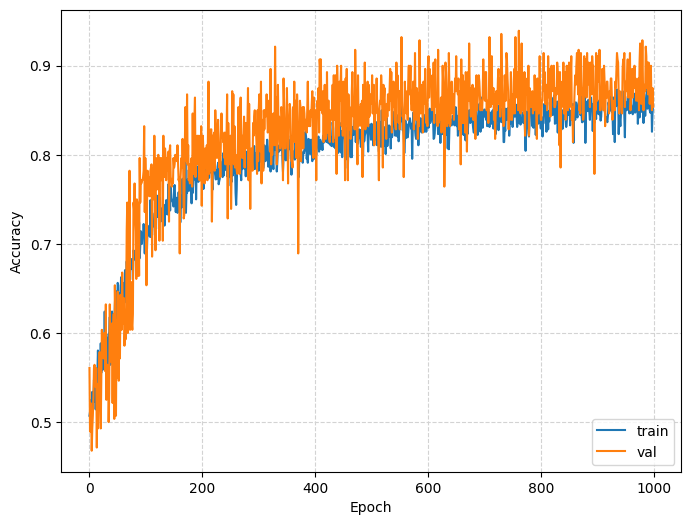

In [12]:
#-----------------------------------------------------------------------------------------------------------
#Accuracy plot
#-----------------------------------------------------------------------------------------------------------
fig = plt.figure(figsize=(8,6))
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.grid(color='lightgray', linestyle='--')
plt.show()

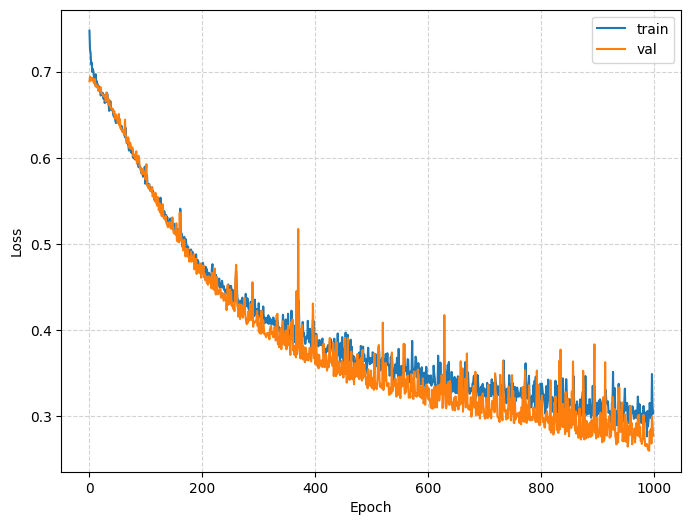

In [13]:
#-----------------------------------------------------------------------------------------------------------
#Loss plot
#-----------------------------------------------------------------------------------------------------------
fig = plt.figure(figsize=(8,6))
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(color='lightgray', linestyle='--')
plt.show()

### Testing the NNs

In [14]:
#Function for the probability of classification as LCDM 
def normMoG(p):
  if 0<p<0.5:
    rr=1-p
  else:
    rr=p
  return rr

#Function for the probability of classification as MoG 
def normLCDM(p):
  if 0<p<0.5:
    rr=p
  else:
    rr=1-p
  return rr

In [15]:
#-----------------------------------------------------------------------------------------------------------
#Test the NN
#-----------------------------------------------------------------------------------------------------------
theory = ['LCDM','MoG']

true_model=[]
pred_model=[]
prob_pred_MoG=[]
prob_pred_LCDM=[]
for i in range(len(X_test)):
  X_test_tf = tf.convert_to_tensor([X_test[i]])
  predictions = model.predict(X_test_tf)
  true_model.append(round(y_test[i]))
  pred_model.append(round(predictions[0][0]))
  prob_pred_MoG.append(round(100*normMoG(predictions[0][0]),3))
  prob_pred_LCDM.append(round(100*normLCDM(predictions[0][0]),3))

1/1 [==============================] - 0s 35ms/step


### Performance verification of the NNs

In [16]:
#-----------------------------------------------------------------------------------------------------------
#Performance: correct & incorrect  predictions
#-----------------------------------------------------------------------------------------------------------
true_LCDM = []
true_MoG = []
false_LCDM = []
false_MoG = []

for pred, true in zip(pred_model, true_model):
    if pred==0 and true==0:
        true_LCDM.append(1)
    if pred==1 and true==1:
        true_MoG.append(1)
    if pred==0 and true==1:
        false_LCDM.append(1)
    if pred==1 and true==0:
        false_MoG.append(1)
lenghts=[len(true_LCDM),len(true_MoG),len(false_LCDM),len(false_MoG)]

print('     ','LCDM','MoG')
print('True ',len(true_LCDM)/sum(lenghts),len(true_MoG)/sum(lenghts))
print('False',len(false_LCDM)/sum(lenghts),len(false_MoG)/sum(lenghts))
print('--------------')
print("Correct prediction: ",(len(true_LCDM)+len(true_MoG))/sum(lenghts))
print("Wrong prediction  : ",(len(false_LCDM)+len(false_MoG))/sum(lenghts))

      LCDM MoG
True  0.5033333333333333 0.365
False 0.13166666666666665 0.0
--------------
Correct prediction:  0.8683333333333333
Wrong prediction  :  0.13166666666666665


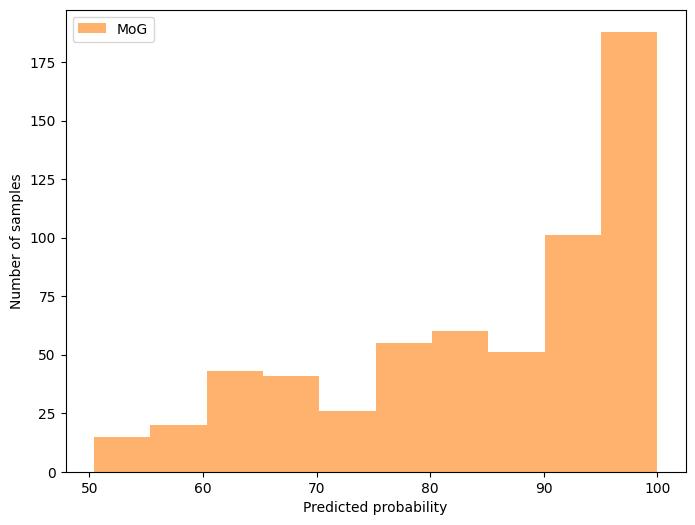

In [17]:
#-----------------------------------------------------------------------------------------------------------
#Probability distribution of classification as MoG
#-----------------------------------------------------------------------------------------------------------
fig = plt.figure(figsize=(8,6))
plt.hist(prob_pred_MoG, label='MoG', alpha=0.6, color='#FF7F0E')
plt.xlabel('Predicted probability')
plt.ylabel('Number of samples')
plt.legend()
plt.show()

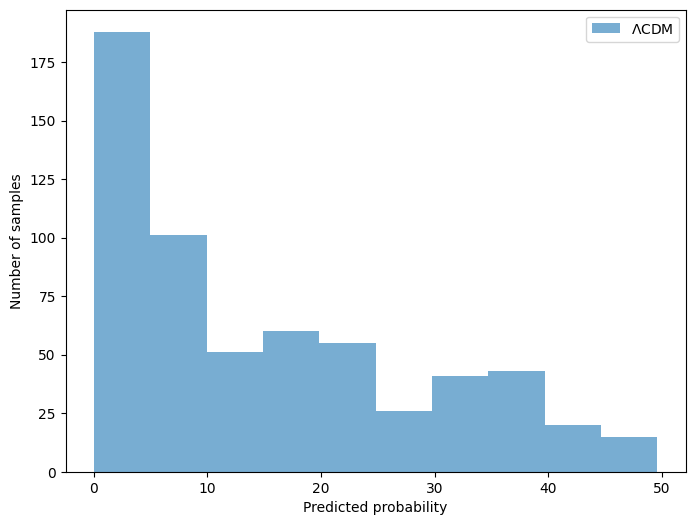

In [18]:
#-----------------------------------------------------------------------------------------------------------
#Probability distribution of classification as LCDM
#-----------------------------------------------------------------------------------------------------------
fig = plt.figure(figsize=(8,6))
plt.hist(prob_pred_LCDM, label='$\Lambda$CDM', alpha=0.6)
plt.xlabel('Predicted probability')
plt.ylabel('Number of samples')
plt.legend()
plt.show()

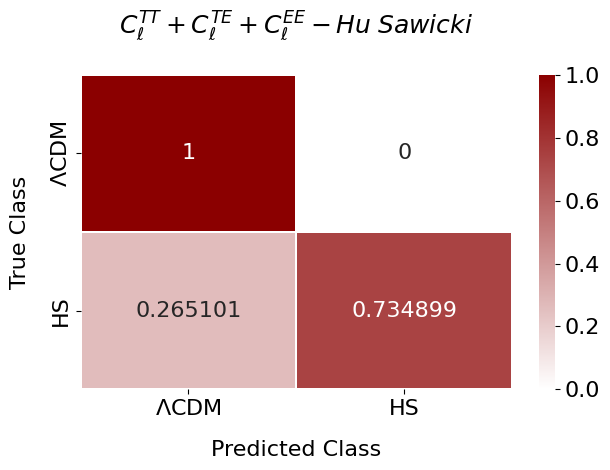

In [21]:
#-----------------------------------------------------------------------------------------------------------
##Confusion matrix
#-----------------------------------------------------------------------------------------------------------
from sklearn import metrics
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

fsize=16
cm = metrics.confusion_matrix(true_model, pred_model)

#Create normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

colors = ["white", "darkred"]
cmap = LinearSegmentedColormap.from_list("gray_to_red", colors)

heatmap = sns.heatmap(cm_normalized, 
            annot=True, 
            annot_kws={"size": fsize},
            linewidths=0.01,
            fmt='g', 
            xticklabels=['$\Lambda$CDM', 'HS'],
            yticklabels=['$\Lambda$CDM', 'HS'], cmap=cmap)
plt.xlabel('Predicted Class', fontsize=fsize, labelpad=15)
plt.ylabel('True Class', fontsize=fsize, labelpad=15)

plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)

colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=fsize)

plt.title('$C_{\ell}^{TT} + C_{\ell}^{TE} +C_{\ell}^{EE} - Hu\;Sawicki$\n', fontsize=18)
plt.tight_layout()
plt.savefig('./figures_MoG/conf_matrix_%s.pdf' %J)
plt.show()